In [279]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/cmac_env/share/proj/'
from dask_jobqueue import PBSCluster
from dask.distributed import Client, metrics, wait
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, progress
import pyart
import netCDF4
import xarray
import tempfile
import shutil
from netCDF4 import num2date
import json
#from time import strftime, sleep
import datetime
import glob
import subprocess
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [302]:
def run_vad(
    radar_file_path, vel_field, z_want):
    """ For dask we need the radar plotting routines all in one subroutine. """
    try:
        radar = pyart.io.read(radar_file_path)
    except OSError:
        return
    
    radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    alt = radar.altitude['data']
    lat = radar.latitude['data']
    lon = radar.longitude['data']
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('reflectivity', 8)
    gatefilter.exclude_below('normalized_coherent_power', 0.80)
    gatefilter.exclude_invalid('velocity')
    corr_vel = pyart.correct.dealias_region_based( 
        radar, vel_field=vel_field, gatefilter=gatefilter, 
        keep_original=False, centered=True)
    radar.add_field('corrected_velocity', corr_vel, replace_existing=True)

    vad = pyart.retrieve.velocity_azimuth_display(radar, 'corrected_velocity', z_want)
    del radar
    
    data = xarray.Dataset()
    data['u_wind'] = vad.u_wind
    data['v_wind'] = vad.v_wind
    data['height'] = vad.height
    data['speed'] = vad.speed
    data['direction'] = vad.direction
    data['time'] = time
    #data['date'] = date
    data['altitude'] = alt
    data['longitude'] = lon
    data['latitude'] = lat
    
    data.to_netcdf('/home/jhemedinger/dev_pyart/vad/data/vad_' + str(time) + '.nc')
    data.close()
    
    return

In [303]:
radar_path = '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/'
#save_name = 'sgpxsaprsecI4.00'
#bad_directory = None
#image_directory = '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprvadI4.png'
#overwrite = True
#verbose = False
vel_field = 'velocity'
z_want = np.linspace(0, 10000, 101)

In [304]:
if os.path.isdir(radar_path):
    #radar_files = glob.glob(radar_path + '/**/*', recursive=True)
    radar_files = glob.glob('/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112*')
elif os.path.isfile(radar_path):
    with open(radar_path) as f:
        radar_files = f.readlines()
    radar_files = [x.strip() for x in radar_files]
else:
    raise IOError('The specified radar path does not exist!')

## Get dates of radar files from the file name.
#radar_times = []
#for file_name in radar_files:
 #   where_x = file_name.find(x_compass)
  #  radar_times.append(
   #     datetime.datetime.strptime(file_name[where_x+3:where_x+15],
    #                               '%y%m%d%H%M%S'))"""

In [305]:
radar_files.sort()
print(radar_files)

['/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112000002.RAWHX8Z', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112001002.RAWHX93', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112002002.RAWHX97', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112003002.RAWHX9B', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112004002.RAWHX9F', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112005002.RAWHX9K', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112010002.RAWHX9P', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112011002.RAWHX9U', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112012002.RAWHX9Y', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112013002.RAWHXA2', '/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.0

In [306]:
#cluster = PBSCluster(name='dask-worker', memory='270GB', cores=36, processes=36, interface='ib0', queue='high_mem', project='arm',
                    #walltime='00:30:00')#, ])
cluster = PBSCluster(cores=8, processes=8, walltime='00:30:00', 
                     queue='batch', memory='100GB', 
                     job_extra=['-W group_list=cades-arm'],
                     scheduler_file='/home/jhemedinger/scheduler.json')
                     #scheduler_file='/home/zsherman/scheduler.json'
cluster.scale(8*8)         # Ask for ten workers
client = Client(cluster)  # Connect this local process to remote workers

In [307]:
cluster

In [309]:
client

Client Scheduler: tcp://10.23.216.82:42650 Dashboard: http://10.23.216.82:39003/status,Cluster Workers: 64 Cores: 64 Memory: 800.00 GB


In [310]:
def com():
    os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/vad/share/proj/'
    #from mpl_toolkits.basemap import Basemap
    return os.environ['PROJ_LIB']
client.run(com)

{'tcp://10.23.216.229:33869': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:34296': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:38226': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:39756': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:40273': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:44245': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:44489': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.229:44493': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.230:33978': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.230:34755': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.230:34763': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.216.230:34912': '/home/jhemedinger/anaconda3/envs/vad/share/proj/',
 'tcp://10.23.21

In [311]:
the_bag = db.from_sequence(radar_files)
the_function = lambda x: run_vad(
    x, vel_field=vel_field, z_want=z_want)
futures = the_bag.map(the_function)

In [312]:
#start computation in the background
futures.compute()
#cluster.stop_all_jobs()

PermissionError: [Errno 13] Permission denied: b'/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T23:40:06.nc'

In [313]:
cluster.stop_all_jobs()

In [314]:
#files = glob.glob('/lustre/or-hydra/cades-arm/proj-shared/practice_vad.c1/vads_20181112/*')
files = glob.glob('/home/jhemedinger/dev_pyart/vad/data/vad_2018*')
files.sort()
print(files)

['/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:00:05.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:10:21.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:20:21.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:30:20.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:40:04.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T00:50:20.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:00:05.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:10:21.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:20:05.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:30:19.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:40:21.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T01:50:21.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T02:00:04.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T02:10:06.nc', '/home/jhemedinger/dev_pyart/vad/data/vad_2018-11-12T02:20:20

In [315]:
u_wind = []
v_wind = []
time = []
height = []
speed = []
direction = []

for file in files:
    try:
        ds = netCDF4.Dataset(file)
    except OSError:
        continue
        
    uwind = ds['u_wind'][:]
    vwind = ds['v_wind'][:]
    spd = ds['speed'][:]
    direc = ds['direction'][:]
    hght = ds['height'][:]
    radar_time = ds['time'][:]
    latitude = ds['latitude'][:]
    longitude = ds['longitude'][:]
    altitude = ds['altitude'][:]
    
    u_wind.append(uwind)
    v_wind.append(vwind)
    time.append(radar_time)
    height.append(hght)
    speed.append(spd)
    direction.append(direc)

In [317]:
new_u_wind = np.array(u_wind)
new_v_wind = np.array(v_wind)
new_time = np.array(time, dtype='datetime64[ns]')
new_height = np.array(hght)
new_speed = np.array(speed)
new_direction = np.array(direction)
lat = np.array(latitude.data, dtype='float64')
lon = np.array(longitude, dtype='float64')
alt = np.array(altitude, dtype='int64')
#height = np.linspace(0,10000,101)

In [331]:
ds = xarray.Dataset()
ds['u_wind'] = xarray.Variable(['time', 'height'], new_u_wind, 
                              attrs={'units': 'm/s', 'long_name': 'Easterly wind component'})
ds['v_wind'] = xarray.Variable(['time', 'height'], new_v_wind, 
                              attrs={'units': 'm/s', 'long_name': 'Westerly wind component'})
ds['speed'] = xarray.Variable(['time', 'height'], new_speed, 
                             attrs={'units': 'm/s', 'long_name': 'Horizontal wind speed'})
ds['direction'] = xarray.Variable(['time', 'height'], new_direction, 
                                 attrs={'units': 'degrees', 'long_name': 'Horizontal wind direction'})
ds.coord['longitude'] = xarray.Variable('longitude', lon, attrs={'units': 'degree_N', 'long_name': "North latitude"})
ds.coord['latitude'] = xarray.Variable('latitude', lat, attrs={'units': 'degree_E', 'long_name': 'East longitude'})
ds.coord['altitude'] = xarray.Variable('altitude', alt, attrs={'units': 'meters', 'long_name': 'altitude above mean sea level'})
ds.coord['time'] = xarray.Variable(['time'], new_time, 
                                   attrs={'long_name': 'Time offset from midnight'})
ds['height'] = xarray.Variable(['height'], new_height, 
                                      attrs={'units': 'meters', 'long_name': 'Height above ground'})
ds.attrs['site_id'] = 'sgp'
ds.attrs['facility_id'] = 'I6: Deer Creek, OK'
ds.attrs['vap_name'] = 'vad'

In [332]:
ds

<xarray.Dataset>
Dimensions:    (altitude: 1, height: 101, latitude: 1, longitude: 1, time: 143)
Coordinates:
  * longitude  (longitude) float64 -97.55
  * latitude   (latitude) float64 36.77
  * altitude   (altitude) int64 17
  * time       (time) datetime64[ns] 2018-11-12T00:00:05 ... 2018-11-12T23:50:20
  * height     (height) float64 0.0 100.0 200.0 300.0 ... 9.8e+03 9.9e+03 1e+04
Data variables:
    u_wind     (time, height) float64 0.001411 -0.004125 ... 0.0003148 0.0003151
    v_wind     (time, height) float64 -0.02145 -0.01654 ... -0.01195 -0.01199
    speed      (time, height) float64 0.0215 0.01705 0.02278 ... 0.01195 0.01199
    direction  (time, height) float64 356.2 14.0 12.44 ... 358.5 358.5 358.5
Attributes:
    site_id:      sgp
    facility_id:  I6: Deer Creek, OK
    vap_name:     vad

In [377]:
data = netCDF4.Dataset('test.nc', 'w', format='NETCDF4')

In [378]:
data.createDimension('time', len(new_time))
data.createDimension('height', len(new_height))

<class 'netCDF4._netCDF4.Dimension'>: name = 'height', size = 101

In [379]:
u_wind = data.createVariable('u_wind', 'f8', ('time', 'height'))
v_wind = data.createVariable('v_wind', 'f8', ('time', 'height'))
speed = data.createVariable('speed', 'f8', ('time', 'height'))
direction = data.createVariable('direction', 'f8', ('time', 'height'))
time = data.createVariable('time', 'f8', 'time')
height = data.createVariable('height', 'f8', 'height')
latitude = data.createVariable('latitude', 'f8')
longitude = data.createVariable('longitude', 'f8')
altitude = data.createVariable('altitude', 'i8')

In [380]:
u_wind.units = 'meters_per_second'
u_wind.long_name = 'easterly wind component'
v_wind.units = 'meters_per_second'
v_wind.long_name = 'northerly wind component'
speed.units = 'meters_per_second'
speed.long_name = 'horizontal wind speed'
direction.units = 'degrees'
direction.long_name = 'horizontal win direction'
latitude.units = 'degrees_north'
latitude.long_name = 'north latitude'
longitude.units = 'degrees_east'
longitude.long_name = 'east longitude'
altitude.units = 'meters'
altitude.long_name = 'height above mean sea level'
time.units = 'seconds since 1970-01-01T00:00:00.0'
height.units = 'meters'
height.long_name = 'height above ground'

In [382]:
time[:] = netCDF4.num2date(new_time, time.units, calendar='standard')

TypeError: invalid type promotion

In [328]:
u_wind[:] = new_u_wind
v_wind[:] = new_v_wind
speed[:] = new_speed
direction[:] = new_direction
latitude[:] = lat
longitude[:] = lon
altitude[:] = alt
time[:] = new_time
height[:] = new_height

In [375]:
ntime = data['time'][:]

masked_array(data=[1.54198080e+18, 1.54198142e+18, 1.54198202e+18,
                   1.54198262e+18, 1.54198320e+18, 1.54198382e+18,
                   1.54198440e+18, 1.54198502e+18, 1.54198560e+18,
                   1.54198622e+18, 1.54198682e+18, 1.54198742e+18,
                   1.54198800e+18, 1.54198861e+18, 1.54198922e+18,
                   1.54198982e+18, 1.54199042e+18, 1.54199100e+18,
                   1.54199162e+18, 1.54199222e+18, 1.54199281e+18,
                   1.54199340e+18, 1.54199402e+18, 1.54199462e+18,
                   1.54199520e+18, 1.54199580e+18, 1.54199642e+18,
                   1.54199700e+18, 1.54199762e+18, 1.54199822e+18,
                   1.54199882e+18, 1.54199940e+18, 1.54200002e+18,
                   1.54200060e+18, 1.54200120e+18, 1.54200180e+18,
                   1.54200242e+18, 1.54200300e+18, 1.54200360e+18,
                   1.54200420e+18, 1.54200480e+18, 1.54200540e+18,
                   1.54200602e+18, 1.54200660e+18, 1.54200722e

In [143]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(144), height(101)
    variables(dimensions): float64 u_wind(time,height), float64 v_wind(time,height), float64 speed(time,height), float64 direction(time,height), float64 latitude(), float64 longitude(), int64 altitude()
    groups: 

In [118]:
ds

<xarray.Dataset>
Dimensions:    (altitude: 1, height: 101, latitude: 1, longitude: 1, time: 144)
Coordinates:
  * longitude  (longitude) float64 -97.55
  * latitude   (latitude) float64 36.77
  * altitude   (altitude) int64 17
  * time       (time) datetime64[ns] 2018-11-12T00:00:05 ... 2018-11-12T23:50:20
  * height     (height) float64 0.0 100.0 200.0 300.0 ... 9.8e+03 9.9e+03 1e+04
Data variables:
    u_wind     (time, height) float64 0.001411 -0.004125 ... 0.0003148 0.0003151
    v_wind     (time, height) float64 -0.02145 -0.01654 ... -0.01195 -0.01199
    speed      (time, height) float64 0.0215 0.01705 0.02278 ... 0.01195 0.01199
    direction  (time, height) float64 356.2 14.0 12.44 ... 358.5 358.5 358.5
Attributes:
    site_id:      sgp
    facility_id:  I6: Deer Creek, OK
    vap_name:     vad

In [120]:
new_u_wind.ndim

2

In [7]:
u = ds.u_wind.data/0.514444
v = ds.v_wind.data/0.514444
z = ds.height.data/1000
C = ds.speed.data/0.514444
t = ds.time.data

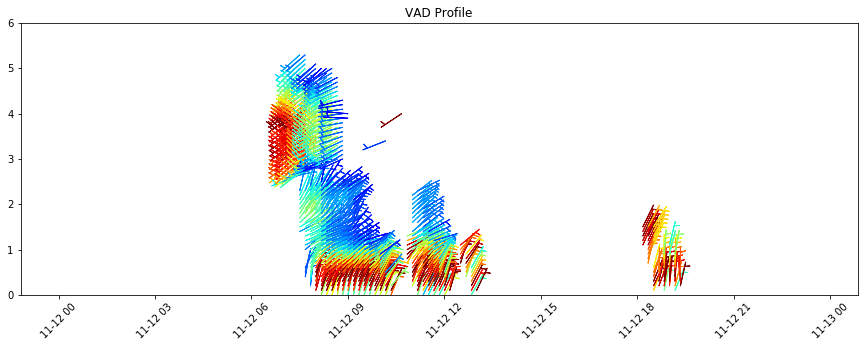

In [14]:
#fig = plt.figure(figsize=[13,8])
#ax = fig.add_subplot(111, )
ax = plt.figure(figsize=[15,5]).add_subplot(111, adjustable='datalim')
for i in range(len(files)-1):
    Xq, Yq = np.meshgrid(t[i], z)
    cmap = plt.cm.jet
    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i], C[i], cmap=cmap, 
                   sizes=dict(emptybarb=0.0), rounding=True)
    
#plt.colorbar(img, cmap=cmap)
plt.title('VAD Profile')
#plt.xlim(datetime.datetime.strftime(datetime.datetime(2018,11,12,6,40,0), '%Y-%m-%dT%H:%M:%S'), 
#         datetime.datetime.strftime(datetime.datetime(2018,11,12,12,45,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0,6)
#plt.savefig('I6_corr_vel.png', dpi=300)
plt.show()
plt.close()

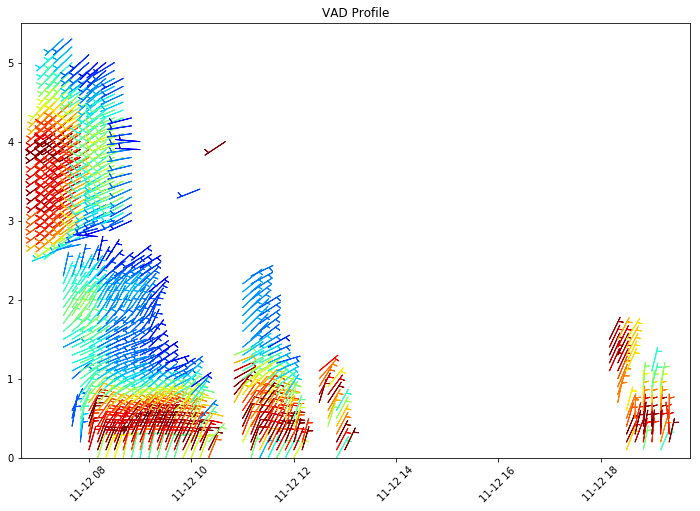

In [41]:
#fig = matplotlib.figure.Figure(figsize=(50,12), subplotpars=dict(wspace=10.0))
#ax = fig.add_subplot(111, )
#ax = plt.figure(figsize=[50,30], subplotpars=dict(wspace=50)).add_subplot(111)
fig = plt.figure(figsize=[12,8])
for i in range(len(files)-1):
    Xq, Yq = np.meshgrid(t[i], z)
    cmap = plt.cm.jet
    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i], C[i], cmap=cmap, 
                   sizes=dict(emptybarb=0.0), rounding=True)
    
#plt.colorbar(img, cmap=cmap)
plt.title('VAD Profile')
plt.xlim(datetime.datetime.strftime(datetime.datetime(2018,11,12,6,40,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2018,11,12,19,45,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
#plt.tick_params(axis='x', which='major', width=80)
plt.ylim(0,5.5)
#plt.savefig('I6_corr_vel.png', dpi=300)
plt.show()
plt.close()

In [71]:
radar.latitude

{'long_name': 'Latitude',
 'standard_name': 'Latitude',
 'units': 'degrees_north',
 'data': array([36.76758103])}

In [76]:
radar.latitude['data'].shape

(1,)

In [82]:
print(np.array(radar.latitude['data']).reshape(1,1))

[[36.76758103]]


In [184]:
radar.time['units']

'seconds since 2018-11-13T15:00:02Z'

In [205]:
datetime.datetime.strftime(datetime.datetime(2018,11,12,0,0,0), '%Y-%m-%dT%H:%M:%S')

'2018-11-12T00:00:00'

In [299]:
radar = pyart.io.read('/lustre/or-hydra/cades-arm/proj-shared/raw_sgpxsaprppiI6.00/201811/XNW181112003002.RAWHX9B')

In [300]:
radar.time['data'][0]

18.278

In [203]:
radar_start_date = netCDF4.num2date(radar.time['data'][0],
                                        radar.time['units'])

In [204]:
radar_start_date

datetime.datetime(2018, 11, 12, 0, 0, 5, 630000)

In [301]:
radar.time['units']

'seconds since 2018-11-12T00:30:02Z'

In [333]:
new_time

array(['2018-11-12T00:00:05.000000000', '2018-11-12T00:10:21.000000000',
       '2018-11-12T00:20:21.000000000', '2018-11-12T00:30:20.000000000',
       '2018-11-12T00:40:04.000000000', '2018-11-12T00:50:20.000000000',
       '2018-11-12T01:00:05.000000000', '2018-11-12T01:10:21.000000000',
       '2018-11-12T01:20:05.000000000', '2018-11-12T01:30:19.000000000',
       '2018-11-12T01:40:21.000000000', '2018-11-12T01:50:21.000000000',
       '2018-11-12T02:00:04.000000000', '2018-11-12T02:10:06.000000000',
       '2018-11-12T02:20:20.000000000', '2018-11-12T02:30:21.000000000',
       '2018-11-12T02:40:19.000000000', '2018-11-12T02:50:05.000000000',
       '2018-11-12T03:00:19.000000000', '2018-11-12T03:10:20.000000000',
       '2018-11-12T03:20:06.000000000', '2018-11-12T03:30:03.000000000',
       '2018-11-12T03:40:21.000000000', '2018-11-12T03:50:19.000000000',
       '2018-11-12T04:00:05.000000000', '2018-11-12T04:10:04.000000000',
       '2018-11-12T04:20:20.000000000', '2018-11-12

In [335]:
numdates = netCDF4.date2num(new_time, datetime.datetime(2018,11,12,0,0,0))

AttributeError: 'datetime.datetime' object has no attribute 'split'

In [362]:
units = datetime.datetime.strftime(datetime.datetime(1970,1,1,0,0,0), '%Y-%m-%dT%H:%M:%SZ')

In [363]:
units

'1970-01-01T00:00:00Z'

In [365]:
nts = netCDF4.date2num(new_time[:], units, calendar='standard')

ValueError: Incorrectly formatted CF date-time unit_string

In [345]:
radar.time['units']

'seconds since 2018-11-12T00:30:02Z'

In [346]:
netCDF4.date2num(new_time[0], datetime.datetime.strftime(datetime.datetime(2018,11,12,0,0,0, '%Y-%m-%dT%H:%M:%S')))

TypeError: an integer is required (got type str)

In [355]:
nts = new_time[0] - np.datetime64('2018-11-12T00:00:00Z')

5000000000 nanoseconds


In [361]:
np.datetime64('1970-01-01T00:00:00Z')

numpy.datetime64('1970-01-01T00:00:00')